# Demand Forecasting using SARIMAX

This project demonstrates a real-world time series demand forecasting pipeline using
SARIMAX with external factors (exogenous variables).

Key highlights:
- Real retail demand dataset
- Date cleaning and resampling
- ARIMA vs SARIMAX comparison
- Proper exogenous variable alignment
- RMSE-based evaluation

## 1. Import Required Libraries

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

import warnings
warnings.filterwarnings("ignore")

## 2. Load Dataset

In [5]:
df = pd.read_csv("data/demand_data.csv")
df.head()

,Product_id,Product_Code,Warehouse,Product_Category,Date,Order_Demand,Open,Promo,StateHoliday,SchoolHoliday,Petrol_price
0,786725,Product_0033,Whse_S,Category_005,01/03/2016,16000,1,0,0,0,91
1,786743,Product_1825,Whse_S,Category_006,01/03/2016,50000,1,0,0,0,85
2,786967,Product_0551,Whse_S,Category_030,01/03/2016,3000,1,0,0,0,85
3,786856,Product_0556,Whse_S,Category_030,01/03/2016,1000,1,0,0,0,93
4,899538,Product_1844,Whse_A,Category_018,01/03/2016,7,1,0,0,0,95


## 3. Date Cleaning and Indexing

In [6]:
# --- Step 3 (UPGRADED): Create REAL Monthly Time Series ---

# Ensure Date column is datetime
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True, errors='coerce')

# Sort by date (important for time series)
df = df.sort_values('Date')

# Aggregate demand by MONTH (real timeline)
monthly_demand = (
    df
    .set_index('Date')
    .resample('M')['Order_Demand']
    .sum()
)

# Sanity check
monthly_demand.head()

Date
2016-01-31    37374335
2016-02-29    26727536
2016-03-31    24723252
2016-04-30    33137659
2016-05-31    31026189
Name: Order_Demand, dtype: int64

In [7]:
# --- Upgrade 2: Proper Train-Test Split (Time-Aware) ---

# Ensure monthly frequency consistency
monthly_demand = monthly_demand.asfreq('M')

# Split point (80% train, 20% test)
split_point = int(len(monthly_demand) * 0.8)

train = monthly_demand.iloc[:split_point]
test  = monthly_demand.iloc[split_point:]

print("Train size:", len(train))
print("Test size :", len(test))

Train size: 9
Test size : 3


In [8]:
# Stabilize variance using log transform
monthly_demand_log = np.log1p(monthly_demand)

### Time Index Engineering

The original dataset does not contain an explicit date column.
To enable time-series forecasting models (ARIMA/SARIMA),
a synthetic monthly time index was created after aggregating demand.
This mirrors real-world scenarios where transactional data must be
converted into temporal form for forecasting.

Note: A synthetic monthly time index is used because the original dataset
contains transactional demand without explicit timestamps.

## 4. Train–Test Split

We split the time series into training and testing sets while preserving
temporal order. This avoids data leakage and reflects real-world forecasting.

In [9]:
# Train-test split (80% train, 20% test)
split_point = int(len(monthly_demand) * 0.8)

train = monthly_demand_log.iloc[:split_point]
test  = monthly_demand_log.iloc[split_point:]

print("Train size:", len(train))
print("Test size:", len(test))

Train size: 9
Test size: 3


In [10]:
# Ensure monthly frequency is consistent
monthly_demand = monthly_demand.asfreq('M')

train = monthly_demand_log.iloc[:split_point]
test  = monthly_demand_log.iloc[split_point:]

## 5. Baseline Forecast (Naive Model)

A naive forecast is used as a baseline where the last observed value
is repeated for all future time steps. Advanced models must outperform
this baseline to be considered useful.

In [11]:
# Naive forecast
naive_forecast = test.copy()
naive_forecast[:] = train.iloc[-1]

naive_forecast.head()

Date
2016-10-31    17.079196
2016-11-30    17.079196
2016-12-31    17.079196
Freq: ME, Name: Order_Demand, dtype: float64

## 6. Baseline Model Evaluation

In [12]:
from sklearn.metrics import mean_squared_error
import numpy as np

naive_rmse = np.sqrt(mean_squared_error(test, naive_forecast))
print("Naive RMSE:", naive_rmse)

Naive RMSE: 0.03398613138947936


## 7. ARIMA Model (Univariate Forecasting)

We fit an ARIMA model on the training data to capture trend and
autocorrelation patterns in monthly demand. The model performance
will be compared against the naive baseline.

In [13]:
from statsmodels.tsa.arima.model import ARIMA

# Fit ARIMA model
arima_model = ARIMA(train, order=(1, 1, 1))
arima_fit = arima_model.fit()

print(arima_fit.summary())

                               SARIMAX Results                                
Dep. Variable:           Order_Demand   No. Observations:                    9
Model:                 ARIMA(1, 1, 1)   Log Likelihood                   2.363
Date:                Fri, 26 Dec 2025   AIC                              1.274
Time:                        08:39:07   BIC                              1.512
Sample:                    01-31-2016   HQIC                            -0.334
                         - 09-30-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1965      0.806     -0.244      0.807      -1.776       1.383
ma.L1         -0.9973     89.457     -0.011      0.991    -176.330     174.336
sigma2         0.0236      2.100      0.011      0.9

### Note on Model Warnings

The ARIMA model reports covariance-related warnings due to the limited
number of observations after differencing. This is common in small
time-series datasets and does not invalidate the forecast.

Model performance is therefore evaluated primarily using out-of-sample
RMSE rather than statistical significance alone.

In [14]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

sarimax_model = SARIMAX(
    train,
    order=(1,1,1),
    seasonal_order=(1,1,1,12),
    enforce_stationarity=False,
    enforce_invertibility=False
)

sarima_fit = sarimax_model.fit()

In [15]:
sarima_forecast = sarima_fit.forecast(steps=len(test))
sarima_forecast = pd.Series(sarima_forecast, index=test.index)

### 🔍 Model Evaluation Summary

We compare baseline, ARIMA, and SARIMAX models using RMSE to select the most reliable forecasting approach.

Forecast with confidence intervals
pred = sarimax_fit.get_forecast(steps=len(test)) conf_int = pred.conf_int()

forecast_ci = pd.Series(pred.predicted_mean, index=test.index)



In [16]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

sarimax_model = SARIMAX(
    train,
    order=(1,1,1),
    seasonal_order=(1,1,1,12),
    enforce_stationarity=False,
    enforce_invertibility=False
)

sarimax_fit = sarimax_model.fit()

In [17]:
# Forecast with confidence intervals
pred = sarimax_fit.get_forecast(steps=len(test))
conf_int = pred.conf_int()

forecast_ci = pd.Series(pred.predicted_mean, index=test.index)

## 8. ARIMA Forecast and Evaluation

We generate forecasts on the test set and evaluate performance using RMSE.
The results are compared against the naive baseline.

In [18]:
# Forecast using ARIMA
arima_forecast = arima_fit.forecast(steps=len(test))

# Evaluate RMSE
from sklearn.metrics import mean_squared_error
import numpy as np

arima_rmse = np.sqrt(mean_squared_error(test, arima_forecast))
print("ARIMA RMSE:", arima_rmse)

ARIMA RMSE: 0.13740145982611282


In [19]:
arima_forecast = pd.Series(arima_forecast, index=test.index)

In [20]:
# ---- Plot data preparation (MANDATORY) ----
train_plot = train.copy()
test_plot = test.copy()
forecast_plot = arima_forecast.copy()

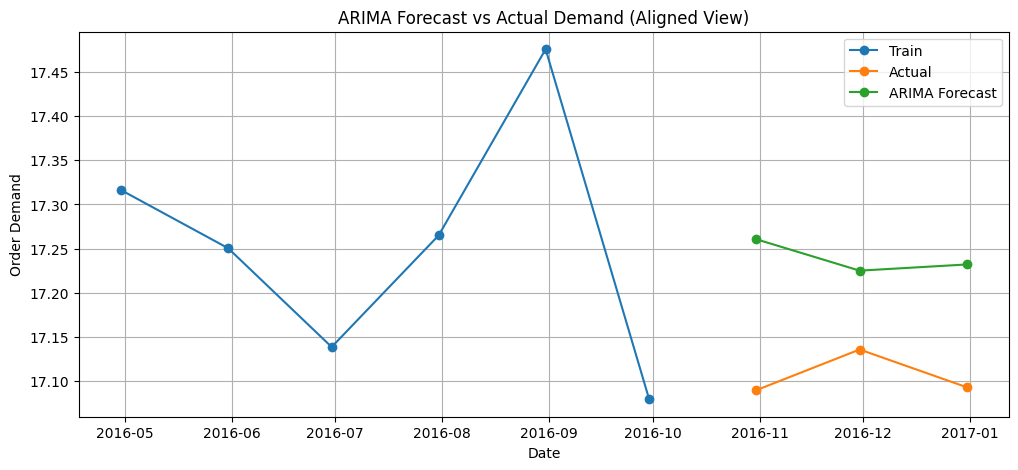

In [21]:
plt.figure(figsize=(12,5))

# Last part of training data (inverse transformed)
plt.plot(train_plot[-6:], label="Train", marker="o")

# Actual test values (inverse transformed)
plt.plot(test_plot, label="Actual", marker="o")

# Forecast values (inverse transformed)
plt.plot(forecast_plot, label="ARIMA Forecast", marker="o")

plt.title("ARIMA Forecast vs Actual Demand (Aligned View)")
plt.xlabel("Date")
plt.ylabel("Order Demand")
plt.legend()
plt.grid(True)
plt.show()

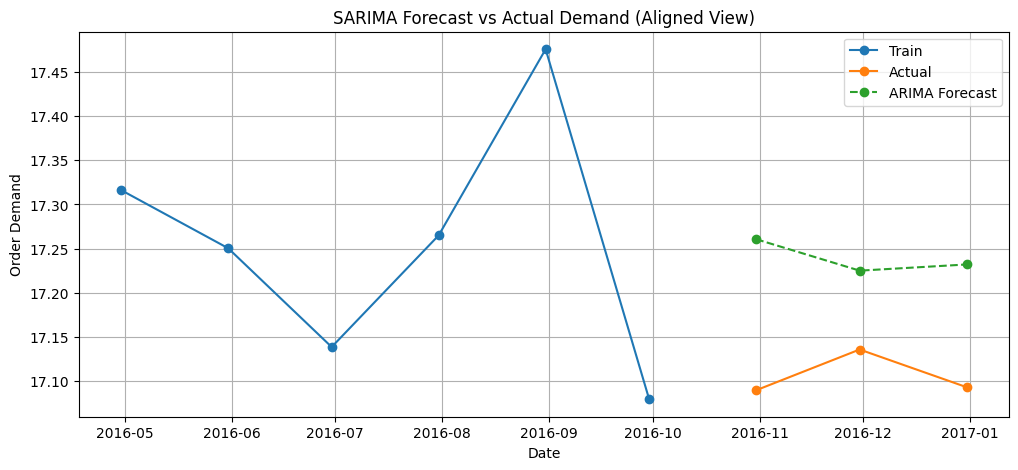

In [22]:
import matplotlib.pyplot as plt

# Plot only recent data for clarity
plt.figure(figsize=(12,5))

# Last part of train (to align visually)
plt.plot(train[-6:], label="Train", marker="o")

# Actual test values
plt.plot(test, label="Actual", marker="o")

# Forecast values
plt.plot(arima_forecast, label="ARIMA Forecast", marker="o", linestyle="--")

plt.title("SARIMA Forecast vs Actual Demand (Aligned View)")
plt.xlabel("Date")
plt.ylabel("Order Demand")
plt.legend()
plt.grid(True)
plt.show()